In [1]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


In [2]:
import sys
sys.path.append('/content/drive/My Drive/ML_trace_predictor/')

In [7]:
import perceptron
import features as f
import numpy as np
import keras
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder

In [4]:
history_length = 4
num_of_classes = 16
ifthenelse_filepath  = '/content/drive/My Drive/ML_trace_predictor/datafiles/ifthenelse/predictionAccuracy.csv'
libquantum_filepath  = '/content/drive/My Drive/ML_trace_predictor/datafiles/short_libquantum/predictionAccuracy.csv'
nested_filepath      = '/content/drive/My Drive/ML_trace_predictor/datafiles/nested/predictionAccuracy.csv'
consecutive_filepath = '/content/drive/My Drive/ML_trace_predictor/datafiles/consecutive/predictionAccuracy.csv'


#one-hot encoding
consecutive_onehot_features, consecutive_onehot_labels = f.generateTraceFeatures(consecutive_filepath, history_length, num_of_classes)
print ("One-hot encoded features: ", consecutive_onehot_features.shape, " Labels: ", consecutive_onehot_labels.shape)

ifthenelse_features, ifthenelse_labels = f.generateTraceFeatures(ifthenelse_filepath, history_length, num_of_classes)
print ("One-hot encoded features: ", consecutive_onehot_features.shape, " Labels: ", consecutive_onehot_labels.shape)

nested_features, nested_onehot_labels = f.generateTraceFeatures(nested_filepath, history_length, num_of_classes)
print ("One-hot encoded features: ", consecutive_onehot_features.shape, " Labels: ", consecutive_onehot_labels.shape)

One-hot encoded features:  (500496, 64)  Labels:  (500496,)
One-hot encoded features:  (500496, 64)  Labels:  (500496,)
One-hot encoded features:  (500496, 64)  Labels:  (500496,)


In [8]:
indices = np.arange(consecutive_onehot_features.shape[0])
np.random.shuffle(indices)
consecutive_onehot_features = consecutive_onehot_features[indices]
consecutive_onehot_labels = consecutive_onehot_labels[indices].reshape(-1,1)
encoder = OneHotEncoder(sparse=False)
encoder.fit(consecutive_onehot_labels)
consecutive_onehot_training_dataset = consecutive_onehot_features[:int(len(consecutive_onehot_features)*0.05)]
consecutive_onehot_training_labels = consecutive_onehot_labels[:int(len(consecutive_onehot_labels)*0.05)]
consecutive_onehot_val_dataset = consecutive_onehot_features[int(len(consecutive_onehot_features)*0.05):int(len(consecutive_onehot_features)*0.1)]
consecutive_onehot_val_labels = consecutive_onehot_labels[int(len(consecutive_onehot_labels)*0.05):int(len(consecutive_onehot_labels)*0.1)]
consecutive_onehot_test_dataset = consecutive_onehot_features[int(len(consecutive_onehot_features)*0.1):]
consecutive_onehot_test_labels = consecutive_onehot_labels[int(len(consecutive_onehot_labels)*0.1):]
consecutive_onehot_training_labels = encoder.transform(consecutive_onehot_training_labels)
consecutive_onehot_val_labels = encoder.transform(consecutive_onehot_val_labels)
consecutive_onehot_test_labels = encoder.transform(consecutive_onehot_test_labels)

In [9]:
indices = np.arange(ifthenelse_features.shape[0])
np.random.shuffle(indices)
ifthenelse_features = ifthenelse_features[indices]
ifthenelse_labels = ifthenelse_labels[indices].reshape(-1,1)
encoder = OneHotEncoder(sparse=False)
encoder.fit(ifthenelse_labels)
ifthenelse_onehot_training_dataset = ifthenelse_features[:int(len(ifthenelse_features)*0.05)]
ifthenelse_onehot_training_labels = ifthenelse_labels[:int(len(ifthenelse_labels)*0.05)]
ifthenelse_onehot_val_dataset = ifthenelse_features[int(len(ifthenelse_features)*0.05):int(len(ifthenelse_features)*0.1)]
ifthenelse_onehot_val_labels = ifthenelse_labels[int(len(ifthenelse_labels)*0.05):int(len(ifthenelse_labels)*0.1)]
ifthenelse_onehot_test_dataset = ifthenelse_features[int(len(ifthenelse_features)*0.1):]
ifthenelse_onehot_test_labels = ifthenelse_labels[int(len(ifthenelse_labels)*0.1):]
ifthenelse_onehot_training_labels = encoder.transform(ifthenelse_onehot_training_labels)
ifthenelse_onehot_val_labels = encoder.transform(ifthenelse_onehot_val_labels)
ifthenelse_onehot_test_labels = encoder.transform(ifthenelse_onehot_test_labels)

In [10]:
indices = np.arange(nested_features.shape[0])
np.random.shuffle(indices)
nested_features = nested_features[indices]
nested_onehot_labels = nested_onehot_labels[indices].reshape(-1,1)
encoder = OneHotEncoder(sparse=False)
encoder.fit(nested_onehot_labels)
nested_onehot_training_dataset = nested_features[:int(len(nested_features)*0.05)]
nested_onehot_training_labels = nested_onehot_labels[:int(len(nested_onehot_labels)*0.05)]
nested_onehot_val_dataset = nested_features[int(len(nested_features)*0.05):int(len(nested_features)*0.1)]
nested_onehot_val_labels = nested_onehot_labels[int(len(nested_onehot_labels)*0.05):int(len(nested_onehot_labels)*0.1)]
nested_onehot_test_dataset = nested_features[int(len(nested_features)*0.1):]
nested_onehot_test_labels = nested_onehot_labels[int(len(nested_onehot_labels)*0.1):]
nested_onehot_training_labels = encoder.transform(nested_onehot_training_labels)
nested_onehot_val_labels = encoder.transform(nested_onehot_val_labels)
nested_onehot_test_labels = encoder.transform(nested_onehot_test_labels)

In [11]:
def create_model(params,num_of_features,loss_fun,num_classes):
    model=keras.Sequential()
    model.add(keras.layers.Dense(units=num_of_features,activation='relu'))
    for i in range (params['layers']):
        model.add(keras.layers.Dense(units=params["N hidden"],activation='relu'))
        model.add(keras.layers.Dropout(params["dropout"]))
    model.add(keras.layers.Dense(num_classes,activation='softmax'))
    Adam=keras.optimizers.Adam(learning_rate=params["lr"],decay=params["lrd"])
    model.compile(optimizer= Adam,loss=loss_fun,metrics=['accuracy'])
    return model

In [12]:
import random
    
def random_search(params,num_iterations,x_train,y_train,x_test,y_test,num_of_features,num_classes,dataset):
    models={}
    mc=keras.callbacks.ModelCheckpoint(monitor='val_accuracy', mode='max', save_best_only=True,verbose=1,filepath='/content/drive/My Drive/ML_trace_predictor/' + dataset + '.h5')
    for i in range (num_iterations):
        print("iteration: "+str(i))
        passing_params={}
        passing_params["layers"] = random.choice(params["layers"])
        passing_params["lr"]=random.choice(params["lr"])
        passing_params["N hidden"]= random.choice(params["N hidden"])
        passing_params["Mini-batch size"]= random.choice(params["Mini-batch size"])
        passing_params ["lrd"]= random.choice(params["lrd"])
        passing_params ["dropout"]=random.choice(params["dropout"])
        print(passing_params)
        model=create_model(passing_params,num_of_features,'categorical_crossentropy',num_classes)
        es=keras.callbacks.EarlyStopping(monitor='val_accuracy', mode='min', verbose=1, patience=4,min_delta=0.05)
        history=model.fit(x_train,y_train,validation_data=(x_test,y_test),epochs=100,batch_size=passing_params["Mini-batch size"],callbacks=[es,mc], verbose=1)
        val_accuracy=history.history['val_accuracy'][-1]
        models.update({str(passing_params):(val_accuracy)})
    return models

params={"lr":[0.0001,0.001,0.01,0.1],
       "dropout":[0,0.3,0.4],
       "N hidden":[4,5,8,10,20,25],
       "Mini-batch size":[8,16,32,64],
        "lrd":[0.0001,0.001,0.01,0.1],
        "layers":[1,2,3,4]
}

In [18]:
consecutive_models = random_search(params,10,consecutive_onehot_training_dataset,consecutive_onehot_training_labels,consecutive_onehot_val_dataset,consecutive_onehot_val_labels,consecutive_onehot_training_dataset.shape[1],consecutive_onehot_training_labels.shape[1],"consecutive")

iteration: 0
{'layers': 3, 'lr': 0.0001, 'N hidden': 8, 'Mini-batch size': 8, 'lrd': 0.1, 'dropout': 0.3}
Epoch 1/100
3124/3128 [============================>.] - ETA: 0s - loss: 1.3601 - accuracy: 0.4238
Epoch 1: val_accuracy improved from -inf to 0.66422, saving model to /content/drive/My Drive/ML_trace_predictor/consecutive.h5
3128/3128 [==============================] - 12s 4ms/step - loss: 1.3600 - accuracy: 0.4238 - val_loss: 1.3529 - val_accuracy: 0.6642
Epoch 2/100
3122/3128 [============================>.] - ETA: 0s - loss: 1.3574 - accuracy: 0.4401
Epoch 2: val_accuracy did not improve from 0.66422
3128/3128 [==============================] - 12s 4ms/step - loss: 1.3574 - accuracy: 0.4401 - val_loss: 1.3512 - val_accuracy: 0.6642
Epoch 3/100
3119/3128 [============================>.] - ETA: 0s - loss: 1.3556 - accuracy: 0.4431
Epoch 3: val_accuracy did not improve from 0.66422
3128/3128 [==============================] - 11s 4ms/step - loss: 1.3556 - accuracy: 0.4428 - val_lo

In [19]:
best_model_consecutive = [key for key, value in consecutive_models.items() if value == max(consecutive_models.values())]
print(best_model_consecutive)

["{'layers': 4, 'lr': 0.1, 'N hidden': 25, 'Mini-batch size': 32, 'lrd': 0.1, 'dropout': 0.4}", "{'layers': 1, 'lr': 0.0001, 'N hidden': 8, 'Mini-batch size': 32, 'lrd': 0.001, 'dropout': 0}", "{'layers': 1, 'lr': 0.001, 'N hidden': 8, 'Mini-batch size': 32, 'lrd': 0.0001, 'dropout': 0.4}", "{'layers': 3, 'lr': 0.001, 'N hidden': 20, 'Mini-batch size': 32, 'lrd': 0.0001, 'dropout': 0.3}"]


In [20]:
best_params_consecutive = {'layers': 4, 'lr': 0.1, 'N hidden': 25, 'Mini-batch size': 32, 'lrd': 0.1, 'dropout': 0.4}

In [21]:
reconstructed_best_model_consecutive = keras.models.load_model("/content/drive/My Drive/ML_trace_predictor/consecutive.h5")

In [22]:
score = reconstructed_best_model_consecutive.evaluate(consecutive_onehot_test_dataset, consecutive_onehot_test_labels, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.1360294222831726
Test accuracy: 0.9990143179893494


In [23]:
ifthenelse_models = random_search(params,10,ifthenelse_onehot_training_dataset,ifthenelse_onehot_training_labels,ifthenelse_onehot_val_dataset,ifthenelse_onehot_val_labels,ifthenelse_onehot_training_dataset.shape[1],ifthenelse_onehot_training_labels.shape[1],"ifthenelse")

iteration: 0
{'layers': 4, 'lr': 0.001, 'N hidden': 25, 'Mini-batch size': 16, 'lrd': 0.0001, 'dropout': 0.3}
Epoch 1/100
1553/1564 [============================>.] - ETA: 0s - loss: 0.2907 - accuracy: 0.8570
Epoch 1: val_accuracy improved from -inf to 0.85882, saving model to /content/drive/My Drive/ML_trace_predictor/ifthenelse.h5
1564/1564 [==============================] - 8s 5ms/step - loss: 0.2907 - accuracy: 0.8571 - val_loss: 0.2709 - val_accuracy: 0.8588
Epoch 2/100
1564/1564 [==============================] - ETA: 0s - loss: 0.2706 - accuracy: 0.8600
Epoch 2: val_accuracy did not improve from 0.85882
1564/1564 [==============================] - 7s 4ms/step - loss: 0.2706 - accuracy: 0.8600 - val_loss: 0.2709 - val_accuracy: 0.8588
Epoch 3/100
1556/1564 [============================>.] - ETA: 0s - loss: 0.2704 - accuracy: 0.8601
Epoch 3: val_accuracy did not improve from 0.85882
1564/1564 [==============================] - 6s 4ms/step - loss: 0.2706 - accuracy: 0.8600 - val_lo

In [24]:
best_model_ifthenelse = [key for key, value in ifthenelse_models.items() if value == max(ifthenelse_models.values())]
print(best_model_ifthenelse)

["{'layers': 4, 'lr': 0.001, 'N hidden': 25, 'Mini-batch size': 16, 'lrd': 0.0001, 'dropout': 0.3}", "{'layers': 1, 'lr': 0.01, 'N hidden': 5, 'Mini-batch size': 8, 'lrd': 0.001, 'dropout': 0.4}", "{'layers': 4, 'lr': 0.1, 'N hidden': 25, 'Mini-batch size': 64, 'lrd': 0.001, 'dropout': 0.4}", "{'layers': 3, 'lr': 0.1, 'N hidden': 10, 'Mini-batch size': 32, 'lrd': 0.1, 'dropout': 0}", "{'layers': 1, 'lr': 0.001, 'N hidden': 25, 'Mini-batch size': 64, 'lrd': 0.01, 'dropout': 0.4}", "{'layers': 2, 'lr': 0.01, 'N hidden': 25, 'Mini-batch size': 16, 'lrd': 0.0001, 'dropout': 0}", "{'layers': 3, 'lr': 0.1, 'N hidden': 20, 'Mini-batch size': 8, 'lrd': 0.0001, 'dropout': 0.4}", "{'layers': 3, 'lr': 0.0001, 'N hidden': 4, 'Mini-batch size': 8, 'lrd': 0.01, 'dropout': 0.4}", "{'layers': 1, 'lr': 0.0001, 'N hidden': 20, 'Mini-batch size': 16, 'lrd': 0.1, 'dropout': 0}", "{'layers': 3, 'lr': 0.001, 'N hidden': 25, 'Mini-batch size': 16, 'lrd': 0.0001, 'dropout': 0.3}"]


In [25]:
best_params_consecutive = {'layers': 4, 'lr': 0.001, 'N hidden': 25, 'Mini-batch size': 16, 'lrd': 0.0001, 'dropout': 0.3}

In [32]:
reconstructed_best_model_ifthenelse = keras.models.load_model("/content/drive/My Drive/ML_trace_predictor/ifthenelse.h5")

In [34]:
score = reconstructed_best_model_ifthenelse.evaluate(ifthenelse_onehot_test_dataset, ifthenelse_onehot_test_labels, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.27308595180511475
Test accuracy: 0.8568932414054871


In [35]:
nested_models = random_search(params,10,nested_onehot_training_dataset,nested_onehot_training_labels,nested_onehot_val_dataset,nested_onehot_val_labels,nested_onehot_training_dataset.shape[1],nested_onehot_training_labels.shape[1],"nested")

iteration: 0
{'layers': 3, 'lr': 0.0001, 'N hidden': 10, 'Mini-batch size': 8, 'lrd': 0.001, 'dropout': 0}
Epoch 1/100
3123/3128 [============================>.] - ETA: 0s - loss: 1.8957 - accuracy: 0.4112
Epoch 1: val_accuracy improved from -inf to 0.59768, saving model to /content/drive/My Drive/ML_trace_predictor/nested.h5
3128/3128 [==============================] - 14s 4ms/step - loss: 1.8954 - accuracy: 0.4115 - val_loss: 1.6055 - val_accuracy: 0.5977
Epoch 2/100
3127/3128 [============================>.] - ETA: 0s - loss: 1.4933 - accuracy: 0.6179
Epoch 2: val_accuracy improved from 0.59768 to 0.62054, saving model to /content/drive/My Drive/ML_trace_predictor/nested.h5
3128/3128 [==============================] - 13s 4ms/step - loss: 1.4932 - accuracy: 0.6179 - val_loss: 1.4057 - val_accuracy: 0.6205
Epoch 3/100
3120/3128 [============================>.] - ETA: 0s - loss: 1.3583 - accuracy: 0.6203
Epoch 3: val_accuracy did not improve from 0.62054
3128/3128 [===================

In [37]:
best_model_nested = [key for key, value in nested_models.items() if value == max(nested_models.values())]
print(best_model_nested)

["{'layers': 3, 'lr': 0.01, 'N hidden': 10, 'Mini-batch size': 8, 'lrd': 0.01, 'dropout': 0}"]


In [38]:
reconstructed_best_model_nested = keras.models.load_model("/content/drive/My Drive/ML_trace_predictor/nested.h5")

In [39]:
score = reconstructed_best_model_nested.evaluate(nested_onehot_test_dataset, nested_onehot_test_labels, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.5434647798538208
Test accuracy: 0.7793281078338623


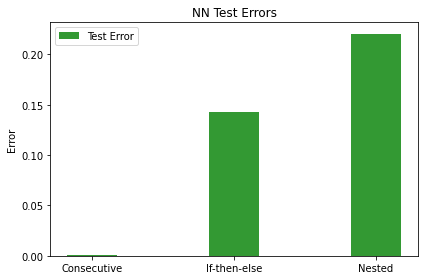

In [43]:
fig, ax = plt.subplots()
index = np.arange(3)
bar_width = 0.35
opacity = 0.8
rects2 = plt.bar(index + bar_width, [1-0.9990,1-0.8568932414054871,1-0.7793281078338623], bar_width,
                    alpha=opacity,
                    color='g',
                    label='Test Error')

plt.ylabel('Error')
plt.title('NN Test Errors')
plt.xticks(index + bar_width, ('Consecutive', 'If-then-else', 'Nested'))
plt.legend()
plt.tight_layout()
plt.show()